## Setup + Data Loading

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
dataset_path = '/content/drive/MyDrive/AI Project/dataset.zip'

In [3]:
!unzip -qo "{dataset_path}" -d "./dataset"

In [4]:
# installing dependencies
!pip install -q "transformers[torch]==4.38.2" accelerate
!pip install -q datasets evaluate

# for augmentations
!pip install -U albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.4/150.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 39.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [5]:
import os
from datasets import Dataset, load_dataset, DatasetDict
import evaluate
from transformers import Trainer, TrainingArguments
from transformers import ViTImageProcessor, ViTForImageClassification
from transformers import BeitImageProcessor, BeitForImageClassification
import torch
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import PIL.Image as Img
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import shutil
import albumentations as A
from uuid import uuid4

## Data Analysis

In [6]:
#del data

In [7]:
data = pd.read_csv('dataset/Training.csv')

In [8]:
data.Image = data.Image.map(lambda x: f'dataset/Training Images/{x}')

In [9]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,MildDemented
1,dataset/Training Images/mildDem1.jpg,MildDemented
2,dataset/Training Images/mildDem10.jpg,MildDemented
3,dataset/Training Images/mildDem100.jpg,MildDemented
4,dataset/Training Images/mildDem101.jpg,MildDemented
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,VeryMildDemented
5117,dataset/Training Images/verymildDem996.jpg,VeryMildDemented
5118,dataset/Training Images/verymildDem997.jpg,VeryMildDemented
5119,dataset/Training Images/verymildDem998.jpg,VeryMildDemented


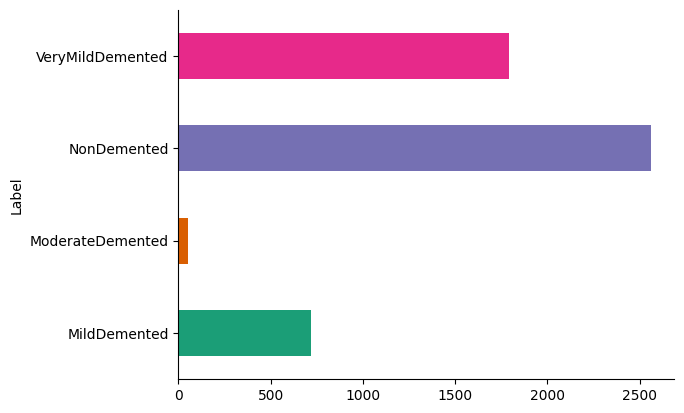

In [10]:
from matplotlib import pyplot as plt
import seaborn as sns
data.groupby('Label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

Image path: dataset/Training Images/nonDem2415.jpg
Label: NonDemented
Image path: dataset/Training Images/verymildDem1167.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem491.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/verymildDem337.jpg
Label: VeryMildDemented
Image path: dataset/Training Images/nonDem15.jpg
Label: NonDemented
Image path: dataset/Training Images/nonDem1856.jpg
Label: NonDemented


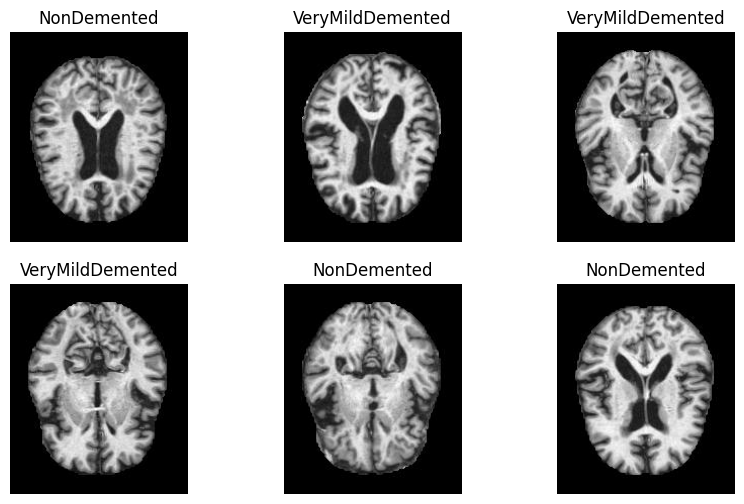

In [11]:
plt.figure(figsize=(10, 6))

for i, idx in enumerate(np.random.choice(len(data), 6)):
    im_path = data.loc[idx, 'Image']  
    label = data.loc[idx, 'Label']    
    print("Image path:", im_path)
    print("Label:", label)


    
    img = cv2.imread(im_path)
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 3, i + 1)
    plt.title(label)
    plt.axis('off')
    plt.imshow(img)

plt.show()

## Training Setup

In [12]:
id2label = {str(i): c for i, c in enumerate(data.Label.unique())}
label2id = {c: str(i) for i, c in id2label.items()}

id2label

{'0': 'MildDemented',
 '1': 'ModerateDemented',
 '2': 'NonDemented',
 '3': 'VeryMildDemented'}

In [13]:
data.Label = data.Label.map(lambda x: int(label2id[x]))

In [14]:
data

,Image,Label
0,dataset/Training Images/mildDem0.jpg,0
1,dataset/Training Images/mildDem1.jpg,0
2,dataset/Training Images/mildDem10.jpg,0
3,dataset/Training Images/mildDem100.jpg,0
4,dataset/Training Images/mildDem101.jpg,0
...,...,...
5116,dataset/Training Images/verymildDem995.jpg,3
5117,dataset/Training Images/verymildDem996.jpg,3
5118,dataset/Training Images/verymildDem997.jpg,3
5119,dataset/Training Images/verymildDem998.jpg,3


In [15]:
image_counts = data['Label'].value_counts()

print(image_counts)

Label
2    2560
3    1792
0     717
1      52
Name: count, dtype: int64


In [16]:
data_limited = pd.DataFrame()  
for label in [0, 2, 3]:
    data_subset = data[data['Label'] == label]
    data_subset_sampled = data_subset.sample(n=600, random_state=42)
    data_limited = pd.concat([data_limited, data_subset_sampled])

data_other_labels = data[~data['Label'].isin([0, 2, 3])]
data_limited = pd.concat([data_limited, data_other_labels])

In [17]:
data_limited

,Image,Label
120,dataset/Training Images/mildDem206.jpg,0
331,dataset/Training Images/mildDem397.jpg,0
39,dataset/Training Images/mildDem133.jpg,0
636,dataset/Training Images/mildDem671.jpg,0
514,dataset/Training Images/mildDem561.jpg,0
...,...,...
764,dataset/Training Images/moderateDem51.jpg,1
765,dataset/Training Images/moderateDem6.jpg,1
766,dataset/Training Images/moderateDem7.jpg,1
767,dataset/Training Images/moderateDem8.jpg,1


In [18]:
image_counts = data_limited['Label'].value_counts()
print(image_counts)

Label
0    600
2    600
3    600
1     52
Name: count, dtype: int64


In [19]:
test = pd.DataFrame()
test = data
data = data_limited.reset_index(drop=True)


In [20]:
image_counts = data['Label'].value_counts()
print(image_counts)

Label
0    600
2    600
3    600
1     52
Name: count, dtype: int64


In [24]:
import albumentations as A
import cv2
import numpy as np
import torch
from torchvision import transforms as T
from torchvision.transforms import functional as F
from uuid import uuid4


!rm -rf augmented_dataset
for id in id2label.keys():
    !mkdir -p augmented_dataset/{id}


transform2 = lambda x, y: (F.rotate(T.ToTensor()(x), y).permute(1, 2, 0).numpy() * 255).astype(np.uint8)


def adjust_brightness_contrast(image):
    transform = A.Compose([
        A.RandomBrightnessContrast(),
    ])
    return transform(image=image)['image']


def rotate_image(image):
    
    return A.Rotate(limit=(-180, 180), p=1)(image=image)['image']


for _, row in data.iterrows():
    img_path, label = row['Image'], row['Label']

    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image at {img_path}")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        img_name = str(uuid4())
        cv2.imwrite(f'augmented_dataset/{label}/{img_name}_0.png', img)

        
        if label == 1: 
          for i in range(10):  
              
              augmented_img = adjust_brightness_contrast(img)
              augmented_img = rotate_image(augmented_img)
              cv2.imwrite(f'augmented_dataset/{label}/{img_name}_{i+1}.png', augmented_img)


In [26]:
dataset = load_dataset('imagefolder', data_dir='augmented_dataset')['train'].train_test_split(0.2)
dataset

Resolving data files:   0%|          | 0/2372 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1897
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 475
    })
})

In [27]:
model_name = "google/vit-base-patch16-224-in21k"


In [28]:
processor = ViTImageProcessor.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [29]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [30]:
def transform(batch):
  inputs = processor(batch['image'], return_tensors='pt')
  inputs['label'] = batch['label']

  return inputs

def collate(batch):
  return {
    'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
    'labels': torch.tensor([x['label'] for x in batch])
  }


accuracy = evaluate.load("accuracy")
def compute_metrics(p):
  predictions, labels = p
  predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [31]:
from evaluate import load

f1_metric = load("f1")
accuracy_metric = load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1 = f1_metric.compute(predictions=predictions, references=labels, average='weighted')
    
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    return {"accuracy": acc["accuracy"], "f1": f1["f1"]}


In [32]:
prepared_dataset = dataset.with_transform(transform)

print(prepared_dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1897
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 475
    })
})


In [35]:
'''model = BeitForImageClassification.from_pretrained(
    model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)'''
model = ViTForImageClassification.from_pretrained(
      model_name,
      num_labels=4,
      id2label=id2label,
      label2id=label2id,
      ignore_mismatched_sizes=True
    )

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
model.to(device)
print()

In [37]:
training_args = TrainingArguments(
  output_dir="./vit_output",
  per_device_train_batch_size=64,
  evaluation_strategy="epoch",
  save_strategy="epoch",
  num_train_epochs=7,
  fp16=True,
  logging_steps=12,
  learning_rate=1e-5,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to='tensorboard',
  load_best_model_at_end=True,
)

trainer = Trainer(
  model=model,
  args=training_args,
  data_collator=collate,
  compute_metrics=compute_metrics,
  train_dataset=prepared_dataset["train"],
  eval_dataset=prepared_dataset["test"],
  tokenizer=processor,
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [38]:
train_results = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.229900,1.150694,0.572632,0.569642
2,0.990100,0.988982,0.654737,0.634128
3,0.901700,0.895816,0.663158,0.630067
4,0.808800,0.838524,0.688421,0.679087
5,0.796200,0.812113,0.688421,0.678490
6,0.761600,0.793142,0.709474,0.703707
7,0.739000,0.787832,0.698947,0.688458


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.229900,1.150694,0.572632,0.569642
2,0.990100,0.988982,0.654737,0.634128
3,0.901700,0.895816,0.663158,0.630067
4,0.808800,0.838524,0.688421,0.679087
5,0.796200,0.812113,0.688421,0.678490
6,0.761600,0.793142,0.709474,0.703707
7,0.739000,0.787832,0.698947,0.688458


***** train metrics *****
  epoch                    =         7.0
  total_flos               = 958363130GF
  train_loss               =      0.9064
  train_runtime            =  0:05:43.46
  train_samples_per_second =      38.662
  train_steps_per_second   =       0.611


In [39]:
metrics = trainer.evaluate(prepared_dataset['test'])

In [40]:
torch.save(model.state_dict(), '/content/drive/MyDrive/AI Project/vit_v1_ckpt_10.pth')

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir vit_output

## Inference on TestSet

In [41]:
inf_model = ViTForImageClassification.from_pretrained(model_name,
    num_labels=4,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


'inf_model = BeitForImageClassification.from_pretrained(\n    model_name,\n    num_labels=4,\n    id2label=id2label,\n    label2id=label2id,\n    ignore_mismatched_sizes=True\n)'

In [42]:
inf_model.to(device)
inf_model.load_state_dict(torch.load('/content/drive/MyDrive/AI Project/vit_v1_ckpt_10.pth'))

<All keys matched successfully>

## New approach to inference

In [43]:
import os
import pandas as pd

def create_image_csv(base_path, output_csv):
    if not os.path.exists(base_path):
        print(f"The specified base path does not exist: {base_path}")
        return

    labels_folders = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
    images_data = []

    for folder in labels_folders:
        folder_path = os.path.join(base_path, folder)
        for img_file in os.listdir(folder_path):
            img_path = os.path.join(folder, img_file)  
            images_data.append({'Image': img_path, 'Label': folder})

    
    df = pd.DataFrame(images_data)
    df.to_csv(output_csv, index=False)
    print(f"CSV created with {len(images_data)} entries.")

create_image_csv('dataset/Testing Images', 'testing_images.csv')


CSV created with 1279 entries.


In [44]:
testset = pd.read_csv('testing_images.csv')
testset['Image'] = testset['Image'].map(lambda x: os.path.join('dataset/Testing Images', x))

testset.head()

,Image,Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,NonDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,NonDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,NonDemented


In [45]:
pred = {}
for x in testset.Image:
  img = cv2.imread(x)
  inputs = processor([Img.open(x).convert('RGB')], return_tensors='pt', device=device).to(device)

  logits = inf_model(**inputs).logits
  predicted_label = logits.argmax(-1).item()

  pred[x] = id2label[str(predicted_label)]

In [46]:
predicted_df = pd.DataFrame(list(pred.items()), columns=['Image', 'Predicted Label'])
predicted_df.to_csv('predictions_output.csv', index=False)

In [47]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

predictions_df = pd.read_csv('predictions_output.csv')


In [48]:
predictions_df

,Image,Predicted Label
0,dataset/Testing Images/NonDemented/26 (89).jpg,VeryMildDemented
1,dataset/Testing Images/NonDemented/32 (45).jpg,NonDemented
2,dataset/Testing Images/NonDemented/26 (70).jpg,NonDemented
3,dataset/Testing Images/NonDemented/27 (3).jpg,MildDemented
4,dataset/Testing Images/NonDemented/30 (98).jpg,MildDemented
...,...,...
1274,dataset/Testing Images/ModerateDemented/30.jpg,ModerateDemented
1275,dataset/Testing Images/ModerateDemented/29.jpg,ModerateDemented
1276,dataset/Testing Images/ModerateDemented/27 (2)...,ModerateDemented
1277,dataset/Testing Images/ModerateDemented/31 (2)...,ModerateDemented


In [49]:
base_path = 'dataset/Testing Images'
labels_folders = os.listdir(base_path)


test_images = []
for folder in labels_folders:
    folder_path = os.path.join(base_path, folder)
    for img in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img)
        test_images.append((img_path, folder))

original_df = pd.DataFrame(test_images, columns=['Image', 'Label'])

In [50]:
results_df = pd.merge(original_df, predictions_df, on='Image', how='left')

results_df.columns = ['Image', 'Actual Label', 'Predicted Label']

print(results_df)


                                                  Image      Actual Label  \
0        dataset/Testing Images/NonDemented/26 (89).jpg       NonDemented   
1        dataset/Testing Images/NonDemented/32 (45).jpg       NonDemented   
2        dataset/Testing Images/NonDemented/26 (70).jpg       NonDemented   
3         dataset/Testing Images/NonDemented/27 (3).jpg       NonDemented   
4        dataset/Testing Images/NonDemented/30 (98).jpg       NonDemented   
...                                                 ...               ...   
1274     dataset/Testing Images/ModerateDemented/30.jpg  ModerateDemented   
1275     dataset/Testing Images/ModerateDemented/29.jpg  ModerateDemented   
1276  dataset/Testing Images/ModerateDemented/27 (2)...  ModerateDemented   
1277  dataset/Testing Images/ModerateDemented/31 (2)...  ModerateDemented   
1278  dataset/Testing Images/ModerateDemented/29 (2)...  ModerateDemented   

       Predicted Label  
0     VeryMildDemented  
1          NonDemented  


In [ ]:
results_df

In [51]:
label2id = {'MildDemented':0,
 'ModerateDemented':1,
'NonDemented':2,
 'VeryMildDemented':3}

results_df['Actual ID'] = results_df['Actual Label'].map(label2id)
results_df['Predicted ID'] = results_df['Predicted Label'].map(label2id)

accuracy = accuracy_score(results_df['Actual ID'], results_df['Predicted ID'])
f1 = f1_score(results_df['Actual ID'], results_df['Predicted ID'], average='weighted')  

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Accuracy: 0.5261923377638781
F1 Score: 0.5515672569765723


In [ ]:
results_df